In [1]:
import os
import pandas as pd
import upsetplot
from functools import reduce
from itertools import combinations

# plotting modules
from matplotlib_venn import venn2, venn2_circles
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = "Arial" # missing fonts:: https://alexanderlabwhoi.github.io/post/2021-03-missingfont/
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams.update({'font.size': 14, 'axes.linewidth': 2, 'xtick.major.width': 1.5, 'xtick.major.size': 5, 'ytick.major.width': 1.5, 'ytick.major.size': 4})
from matplotlib.backends.backend_pdf import PdfPages

/data5/deepro/miniconda3/envs/starrseq/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
groups = ["combo_bottom_prs", "combo_top_prs"]

gene_files = [
    "/data6/deepro/ukb_bmi/3_characterization/data/pilot/combo_bottom_prs_enrich/genes.list",
    "/data6/deepro/ukb_bmi/3_characterization/data/pilot/combo_top_prs_enrich/genes.list",
    ]

go_enrich_files = [
    "/data6/deepro/ukb_bmi/3_characterization/data/pilot/combo_bottom_prs_enrich/GO_Biological_Process_2023_enrich.csv",
    "/data6/deepro/ukb_bmi/3_characterization/data/pilot/combo_top_prs_enrich/GO_Biological_Process_2023_enrich.csv",
]

kegg_enrich_files = [
    "/data6/deepro/ukb_bmi/3_characterization/data/pilot/combo_bottom_prs_enrich/KEGG_2021_Human_enrich.csv",
    "/data6/deepro/ukb_bmi/3_characterization/data/pilot/combo_top_prs_enrich/KEGG_2021_Human_enrich.csv"
]

In [3]:
def read_genes(gene_file):
    with open(gene_file, "r") as f:
        genes = set([g.strip() for g in f.readlines()])
    return genes

def set_add(a, b):
    return a.intersection(b)

def set_subtract(a,b):
    return a.difference(b)

def get_intersects(include_sets, exclude_sets):
    intersect_sets = reduce(set_add, include_sets)
    if len(exclude_sets)>0:
        exclude_sets = [intersect_sets] + exclude_sets
        intersect_sets = reduce(set_subtract, exclude_sets)
    return intersect_sets

def get_upset_df(group_sets, groups):
    # get the set of items for each group
    item_dict = {g: s for g,s in zip(groups, group_sets)}
    item_boolean_dict = {g:[] for g in groups}
    counts = []
    unique_intersect_sets = dict()
    for i in range(1, len(groups) + 1):
        # get combinations of length i
        all_items = list(combinations(groups, i))
        for items in all_items:
            # get counts of elements that are unique to the group
            include_items = items
            exclude_items = tuple(g for g in groups if g not in include_items)
            include_sets = [item_dict[c] for c in include_items]
            exclude_sets = [item_dict[c] for c in exclude_items]
            unique_intersects = get_intersects(include_sets, exclude_sets)
            counts.append(len(unique_intersects))
            unique_intersect_sets[(include_items, exclude_items)] = unique_intersects
            for c in include_items:
                item_boolean_dict[c].append(True)
            for c in exclude_items:
                item_boolean_dict[c].append(False)
    item_boolean_dict["counts"] = counts
    df = pd.DataFrame(item_boolean_dict)
    return df.set_index(groups), unique_intersect_sets

# Genes

In [4]:
group_genes = list(map(read_genes, gene_files))

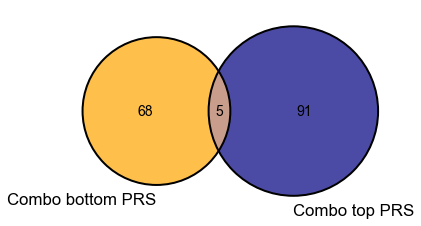

In [5]:
fig, ax = plt.subplots(1,1,figsize=(6,5))
venn2(group_genes, set_labels = ('Combo bottom PRS', 'Combo top PRS'), set_colors=("orange", "navy"), alpha=0.7, ax=ax)
venn2_circles(group_genes, ax=ax)

In [6]:
gene_upset_df, gene_unique_intersects = get_upset_df(group_genes, groups)

In [7]:
gene_unique_intersects[(('combo_bottom_prs', 'combo_top_prs'), ())]

{'CFTR', 'PCDHGB2', 'SCN5A', 'TENM4', 'TTN'}

(0.0, 1.0, 0.0, 1.0)

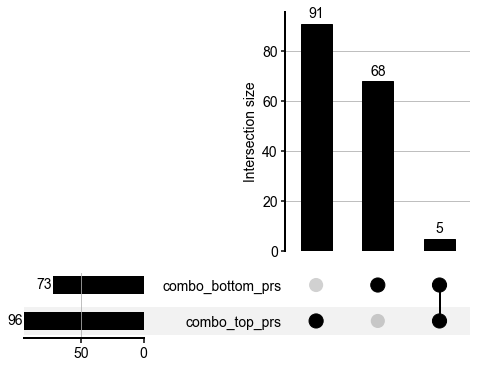

In [8]:
parsed_gene_upset_df = gene_upset_df.loc[gene_upset_df.counts>0]
fig,ax = plt.subplots(1,1, figsize=(8, 6))
upsetplot.plot(parsed_gene_upset_df.counts, show_counts=True, fig=fig, element_size=None)
ax.axis("off")

# GO terms

In [9]:
def read_enrich_files(filename):
    df = pd.read_csv(filename)
    df = df.loc[df.adj_pval<0.05]
    return set(df["Term"])

In [10]:
group_gos = list(map(read_enrich_files, go_enrich_files))

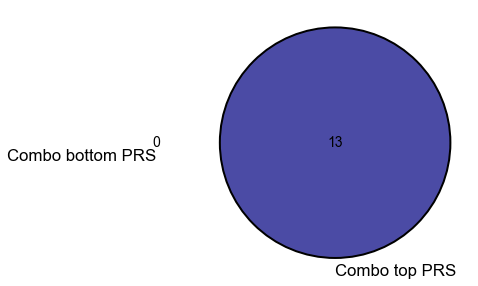

In [11]:
fig, ax = plt.subplots(1,1,figsize=(6,5))
venn2(group_gos, set_labels = ('Combo bottom PRS', 'Combo top PRS'), set_colors=("orange", "navy"), alpha=0.7, ax=ax)
venn2_circles(group_gos, ax=ax)

(0.0, 1.0, 0.0, 1.0)

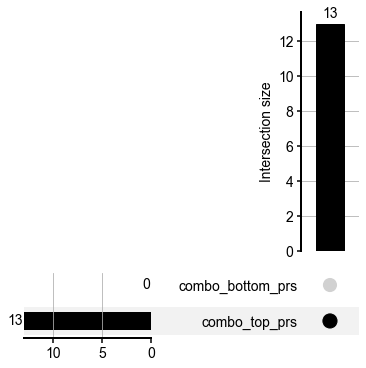

In [12]:
go_upset_df, go_unique_intersects = get_upset_df(group_gos, groups)
parsed_go_upset_df = go_upset_df.loc[go_upset_df.counts>0]
fig,ax = plt.subplots(1,1, figsize=(6, 6))
upsetplot.plot(parsed_go_upset_df.counts, show_counts=True, fig=fig, element_size=None)
ax.axis("off")

# KEGG terms

In [13]:
group_keggs = list(map(read_enrich_files, kegg_enrich_files))

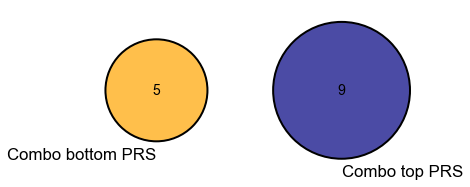

In [14]:
fig, ax = plt.subplots(1,1,figsize=(6,5))
venn2(group_keggs, set_labels = ('Combo bottom PRS', 'Combo top PRS'), set_colors=("orange", "navy"), alpha=0.7, ax=ax)
venn2_circles(group_keggs, ax=ax)

(0.0, 1.0, 0.0, 1.0)

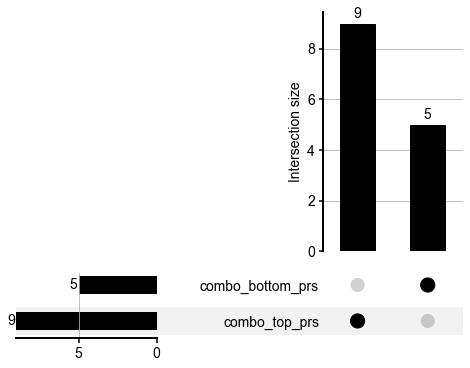

In [15]:
kegg_upset_df, kegg_unique_intersects = get_upset_df(group_keggs, groups)
parsed_kegg_upset_df = kegg_upset_df.loc[kegg_upset_df.counts>0]
fig,ax = plt.subplots(1,1, figsize=(8, 6))
upsetplot.plot(parsed_kegg_upset_df.counts, show_counts=True, fig=fig, element_size=None)
ax.axis("off")

In [16]:
kegg_unique_intersects

{(('combo_bottom_prs',), ('combo_top_prs',)): {'ABC transporters',
  'Fatty acid biosynthesis',
  'Glycine serine and threonine metabolism',
  'Glyoxylate and dicarboxylate metabolism',
  'Lysosome'},
 (('combo_top_prs',),
  ('combo_bottom_prs',)): {'Ascorbate and aldarate metabolism', 'Bile secretion', 'Chemical carcinogenesis', 'Drug metabolism', 'Metabolism of xenobiotics by cytochrome P450', 'Pentose and glucuronate interconversions', 'Porphyrin and chlorophyll metabolism', 'Retinol metabolism', 'Steroid hormone biosynthesis'},
 (('combo_bottom_prs', 'combo_top_prs'), ()): set()}

# KEGG unique intersect genes

## Bottom

In [17]:
kegg_bottom_df = pd.read_csv(kegg_enrich_files[0])

In [18]:
def get_unique_genes_from_terms(enrich_df, term_unique_intersects, gene_unique_intersects, ut_key):
    unique_terms = term_unique_intersects[ut_key]
    enrich_df = enrich_df.loc[enrich_df.Term.isin(unique_terms)]
    unique_genes = gene_unique_intersects[ut_key]
    enrich_df["genes"] = enrich_df.genes.apply(lambda x: "|".join(set(x.split("|")).intersection(unique_genes)))
    return enrich_df
    

In [19]:
get_unique_genes_from_terms(kegg_bottom_df, kegg_unique_intersects, gene_unique_intersects, (('combo_bottom_prs',), ('combo_top_prs',)))

/tmp/ipykernel_98217/3387058214.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enrich_df["genes"] = enrich_df.genes.apply(lambda x: "|".join(set(x.split("|")).intersection(unique_genes)))


,Term,p_val,adj_pval,odds_ratio,combined_score,genes
0,Glyoxylate and dicarboxylate metabolism,0.000219,0.023177,29.344444,247.315561,ACO1|GLYCTK|GLDC
1,Glycine serine and threonine metabolism,0.000480,0.025433,21.997619,168.105584,GCAT|GLYCTK|GLDC
2,ABC transporters,0.000733,0.025886,18.848980,136.068469,ABCA13|ABCA4
3,Lysosome,0.001572,0.041662,8.667845,55.953543,SLC11A1|NPC1|SORT1|CLN5
4,Fatty acid biosynthesis,0.001992,0.042223,34.739906,216.040419,OXSM|MCAT


## Top

In [20]:
kegg_top_df = pd.read_csv(kegg_enrich_files[1])
get_unique_genes_from_terms(kegg_top_df, kegg_unique_intersects, gene_unique_intersects, (('combo_top_prs',), ('combo_bottom_prs',)))

/tmp/ipykernel_98217/3387058214.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enrich_df["genes"] = enrich_df.genes.apply(lambda x: "|".join(set(x.split("|")).intersection(unique_genes)))


,Term,p_val,adj_pval,odds_ratio,combined_score,genes
0,Ascorbate and aldarate metabolism,2.329882e-14,2.236687e-12,90.985222,2856.060108,UGT1A1|UGT1A10|UGT1A8|UGT1A9|UGT1A7|UGT1A5|UGT...
1,Pentose and glucuronate interconversions,8.398754e-14,4.031402e-12,76.411034,2300.591670,UGT1A1|UGT1A10|UGT1A8|UGT1A9|UGT1A7|UGT1A5|UGT...
2,Porphyrin and chlorophyll metabolism,8.693501e-13,2.435759e-11,56.157201,1559.543337,UGT1A1|UGT1A10|UGT1A8|UGT1A9|UGT1A7|UGT1A5|UGT...
3,Bile secretion,1.014900e-12,2.435759e-11,30.549472,843.661292,UGT1A1|UGT1A10|UGT1A8|UGT1A9|UGT1A7|UGT1A5|UGT...
4,Steroid hormone biosynthesis,1.810669e-11,3.476485e-10,38.153793,943.724135,UGT1A1|UGT1A10|UGT1A8|UGT1A9|UGT1A7|UGT1A5|UGT...
5,Retinol metabolism,5.956639e-11,9.530622e-10,32.876932,774.052179,UGT1A1|UGT1A10|UGT1A8|UGT1A9|UGT1A7|UGT1A5|UGT...
6,Metabolism of xenobiotics by cytochrome P450,1.160954e-10,1.592165e-09,30.259442,692.233413,UGT1A1|UGT1A10|UGT1A8|UGT1A9|UGT1A7|UGT1A5|UGT...
7,Drug metabolism,3.273878e-09,3.928654e-08,20.031942,391.369870,UGT1A1|UGT1A10|UGT1A8|UGT1A9|UGT1A7|UGT1A5|UGT...
8,Chemical carcinogenesis,2.042545e-07,2.178715e-06,10.122370,155.923963,UGT1A1|UGT1A10|UGT1A8|UGT1A9|UGT1A7|RXRG|UGT1A...
